In [1]:
import s3fs
import boto3

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc
import matplotlib.pyplot as plt
import time

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split

In [2]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [4]:
def data_loading(path):
    with open(path, 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    
    # zijn die waardes hier altijd static? Of kan dat verschillen?
    # je kan ook bv een config maken (json file of een dict) waar je deze waardes in zet, 
    # dan kan je daarmee dingen uittesten met andere waardes
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
    return train_x, test_x, train_y, test_y

In [5]:
def data_loading_COMPCAR():
    train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')

    with open('COMPCAR.json', 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(x, y, test_size=0.90, random_state=42,stratify=y)

    train_x.extend(train_x_2)
    train_y.extend(train_y_2)
    
    test_x.extend(test_x_2[:1500])
    test_y.extend(test_y_2[:1500])
    return train_x, test_x, train_y, test_y

In [6]:
def preprocess_image(image_bytes):
    # Open the image as bytes
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(model, image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    
    # zou hier list maken en dan check if model in list: in plaats van 4 if statements -> zou trouwens elif doen 
    models = ['ResNet','VGG16', 'SVM', 'YOLO']
    if model in models:
        preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),])

    image_tensors = []
    for i in range(0, len(image_paths), batch_size):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes)
                batch_image_tensors.append(image_tensor)
                
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [7]:
def run_VGG(im):
    # wat voor object is im? staat niet in je func namelijk
    ## Load pre-trained VGG model
    weights = VGG16_Weights.DEFAULT
    vgg_model = models.vgg16(weights = weights)
    vgg_model.eval()

    preprocess = weights.transforms()
    image_tensors = im
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(image_tensors)

    labels= []
    start_time = time.time()
    with torch.no_grad():
        predictions = vgg_model(batch).softmax(1)
        top_probs, top_indices = torch.topk(predictions, k=7, dim=1)
        
        

        for i in range(len(image_tensors)):
            #print(f"Predictions for image {i + 1}:")
            image_labels = [] 
            for j in range(7):  # Top 3 predictions
                class_id = top_indices[i][j].item()
                score = top_probs[i][j].item()
                category_name = weights.meta["categories"][class_id]
                if score > 0.01:
                    image_labels.append(category_name)
                else:
                    category_name = ''
                    image_labels.append(category_name)

                #print(f"{j + 1}. {category_name}: {100 * score:.1f}%")

            labels.append(image_labels)
            #print()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return labels

In [8]:
def get_result(labels):
    exterior = ['ambulance','car wheel','racer','golfcart','mobile home','beach wagon', 
                'convertible','garbage truck','jeep', 'limousine', 'mini bus','minibus',
                'minivan','mini van','moving van', 'passenger car','recreational vehicle', 'school bus', 
                'sports car','trailor truck','trolley bus', 'cab', 'freight car', 'police van', 'grille', 'pickup']

    result_VGG = [1 if (sublist[0] in exterior or sublist[1] in exterior or sublist[2] in exterior)
                  else 0 for sublist in labels]

    result_VGG = [0 if ('seat belt' in sublist or 'sliding door' in sublist or 'stretcher' in sublist
                        or 'odometer' in sublist or 'radio' in sublist or 'cassette player' in sublist
                        or 'loudspeaker' in sublist or 'barber chair' in sublist or 'electric fan' in sublist
                        or 'desk' in sublist or 'microwave' in sublist or 'home theater' in sublist
                        or 'dining table' in sublist or 'folding chair' in sublist or 'studio couch' in sublist
                        or 'neck brace' in sublist) else val for sublist, val in zip(labels, result_VGG)]
    return result_VGG

In [9]:
def show_matrix(test_y,result_VGG,filename=None):
    print(classification_report(test_y, result_VGG))
    cm = confusion_matrix(test_y, result_VGG)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interior','exterior'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [10]:
def main_VGG():
    _, test_x, _, test_y = data_loading_COMPCAR()
    gc.collect()
    im = process_duplicates_image_ids('VGG16',image_paths=test_x,batch_size=32,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
    label = run_VGG(im)
    result = get_result(label)
    show_matrix(test_y,result,filename='VGG_results.png')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s] 


Time taken for testing: 91.38785552978516 seconds
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1477
           1       0.92      0.88      0.90      1184

    accuracy                           0.92      2661
   macro avg       0.92      0.91      0.91      2661
weighted avg       0.92      0.92      0.92      2661



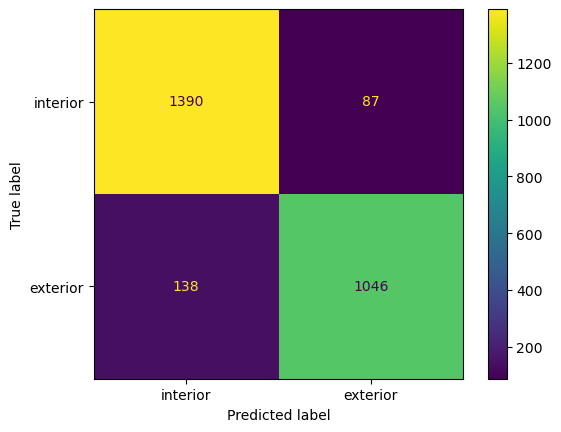

In [11]:
main_VGG()

# Trained VGG (re train fc layers)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        target_tensor = torch.tensor([target], dtype=torch.float32)

        return image, target_tensor

def dataloader(im,train_y,im_test,test_y):
    train_images, val_images, train_targets, val_targets = train_test_split(im, train_y, test_size=0.3, random_state=42,stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets)
    val_dataset = CustomDataset(val_images, val_targets)
    test_dataset = CustomDataset(im_test, test_y)
    
    # deze vars zijn beetje gek hier geconstruct
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    return train_loader,val_loader,test_loader

In [13]:
def train_trainedVGG(epochs,train_loader,val_loader):
    start_time = time.time()

    # we kunnen evt je training nog met MLFlow uitbreiden, zou wel smooth zijn - maar niet necessity
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False   

    model.classifier[-1] = nn.Sequential(
        nn.Linear(4096, 1), 
        nn.Sigmoid()
    ).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.classifier.parameters())


    num_epochs = epochs
    train_loss = []
    validation_loss = []
    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets).to(device)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, targets)

        train_loss.append(loss.item())
        validation_loss.append(val_loss.item())
        combined_loss = loss.item() + val_loss.item()
        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
            best_model_state = model.state_dict()
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    plt.plot([x for x in range(num_epochs)],train_loss, label='Training set')
    plt.plot([x for x in range(num_epochs)],validation_loss,label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and validation error VGG16')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()
    torch.save(model.state_dict(), 'model_VGG16.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return best_model_state,model

In [14]:
def test_VGG(best_model_state,model,test_loader):
    start_time = time.time()
    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs)

    predictions = torch.cat(predictions, dim=0).to(device)
    threshold = 0.5
    predicted_labels = (predictions > threshold).float()

    predicted_labels = predicted_labels.int()

    result = predicted_labels.squeeze().tolist()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return result

In [15]:
# train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')
# gc.collect()
# im = process_duplicates_image_ids('VGG',image_paths=train_x,batch_size=100,bucket="s3-path",
#         boto_s3=boto3_s3,
#         s3fs_=s3fs_)
# im_test = process_duplicates_image_ids('VGG',image_paths=test_x,batch_size=100,bucket="s3-path",
#         boto_s3=boto3_s3,
#         s3fs_=s3fs_)

In [16]:
def main_trainedVGG16():
    # zoals eerder, voor al deze strings zou ik met config werken - 
    # dan kan je altijd namelijk die als env vars ook meenemen evt maar verder prima
    # zou je functies wel meer met args laten werken, wat het returnt etc
    # zal je van de week wel laten zien wat ik bedoel op kantoor
    train_x, test_x, train_y, test_y = data_loading_COMPCAR()
    gc.collect()
    im = process_duplicates_image_ids('VGG',image_paths=train_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    im_test = process_duplicates_image_ids('VGG',image_paths=test_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    train_loader,val_loader,test_loader = dataloader(im,train_y,im_test,test_y)
    best_model,model = train_trainedVGG(30,train_loader,val_loader)
    result = test_VGG(best_model,model,test_loader)
    show_matrix(test_y,result,filename='trainedVGG16_results.png')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Tensor Shape: torch.Size([5324, 3, 256, 256])
Tensor Dtype: torch.float32
Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 216MB/s] 


Epoch 1/30, Train Loss: 0.05923619866371155, Val Loss: 0.09697141498327255
Epoch 2/30, Train Loss: 0.16932035982608795, Val Loss: 0.07777675241231918
Epoch 3/30, Train Loss: 0.46516120433807373, Val Loss: 0.06728070974349976
Epoch 4/30, Train Loss: 0.009767244569957256, Val Loss: 0.07143540680408478
Epoch 5/30, Train Loss: 0.023578094318509102, Val Loss: 0.0649896040558815
Epoch 6/30, Train Loss: 0.19624997675418854, Val Loss: 0.058265674859285355
Epoch 7/30, Train Loss: 0.07098785042762756, Val Loss: 0.08208699524402618
Epoch 8/30, Train Loss: 0.07046055793762207, Val Loss: 0.05508919432759285
Epoch 9/30, Train Loss: 0.020221993327140808, Val Loss: 0.04448441416025162
Epoch 10/30, Train Loss: 0.04254923388361931, Val Loss: 0.04567642882466316
Epoch 11/30, Train Loss: 0.13564664125442505, Val Loss: 0.0561407133936882
Epoch 12/30, Train Loss: 0.023848973214626312, Val Loss: 0.05155986547470093
Epoch 13/30, Train Loss: 0.019980404525995255, Val Loss: 0.042113132774829865
Epoch 14/30, Tra

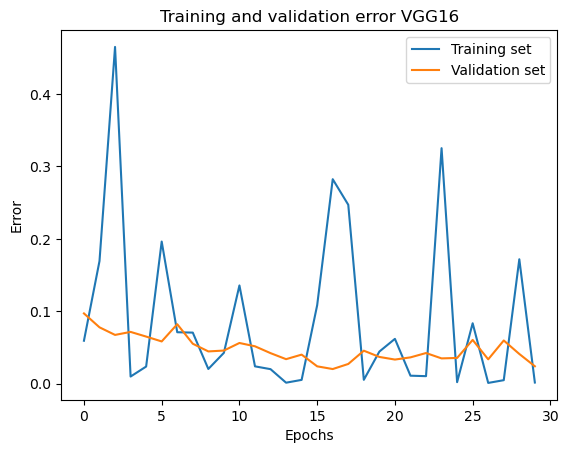

Time taken for training: 917.3333644866943 seconds
Time taken for testing: 14.805078268051147 seconds
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1477
           1       0.99      0.95      0.97      1184

    accuracy                           0.97      2661
   macro avg       0.98      0.97      0.97      2661
weighted avg       0.97      0.97      0.97      2661



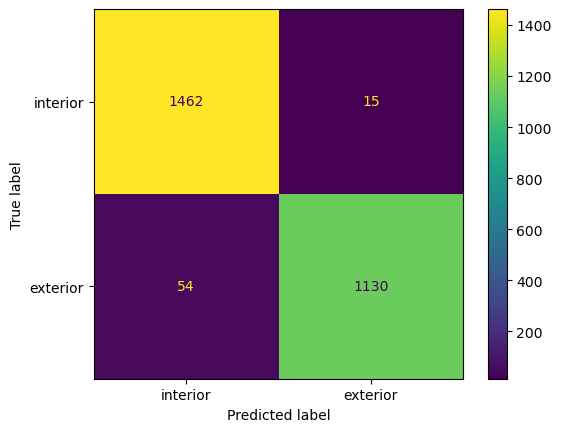

In [17]:
main_trainedVGG16()